## Look at calibrated spectra
Glen Langston, NSF, 2021 October 27
### After calibration and selecting the low galactic latitude data, the averages are saved in a sub-directory
Now check the calibration and velocities saved

In [1]:
datadir = "./keep/"
!ls {datadir}

T0-21-09-29T103456.kel T0-21-10-10T103920.kel T0-21-10-26T104009.kel
T0-21-09-30T004021.kel T0-21-10-10T231148.kel T0-21-10-26T205337.kel


In [2]:
# Import the processing routines
import ras

In [3]:
p = ras.Plot(datadir)

In [6]:
p.Help("-V "+datadir)

Arg[0] = -V
Arg[1] = ./keep/
Observation Files and Directories:
['./keep/']


['./keep/']

In [54]:
# alternateivly just select 1 file to plot
datadir = "./keep/T0-21-10-26T104009.kel"

Ploting Intensity versus Velocity
Date: 2021-10-26
Imin Error computing baseline:  -25
  Time   AZ,EL (deg)  Lon,Lat (deg)    Max   Median    Count  
10:40:09 180.0, 30.0  237.4,  0.2   33.239    0.266    427500


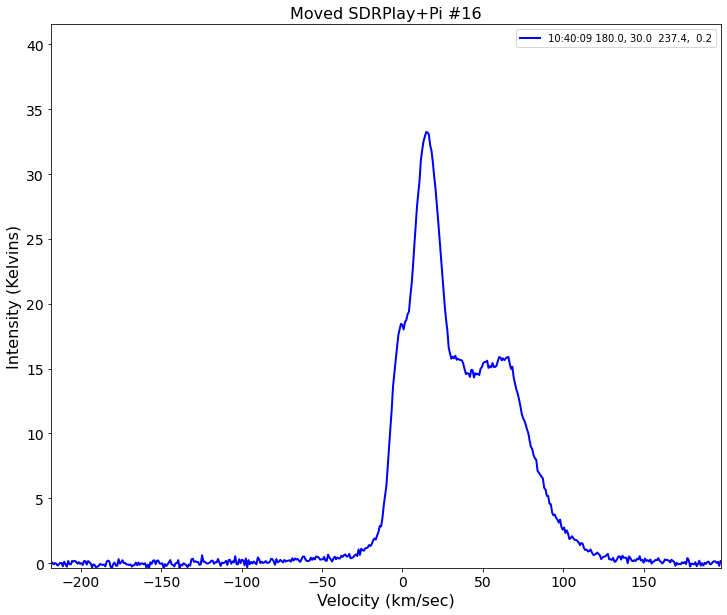

In [55]:
p.raw(datadir)

In [56]:
# Now prepare to fit two gaussians to last spectrum averaged

In [57]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from scipy import optimize
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
%matplotlib inline

In [58]:
# Retrieve the data from the lastest plot
x_array = p.xv
y_array = p.yv
bunit = "Kelvins"
print("Length of arrays to fit: %d, %d" % (len(x_array),len(y_array)))
xunit = "MHz"
if not p.plotFrequency:
    xunit = "km/sec"
print("X min, max: %8.3f, %8.3f (%s)" % (np.min(x_array), np.max(x_array), xunit))
print("Y min, max: %8.3f, %8.3f (%s)" % (np.min(y_array), np.max(y_array), bunit))

# prepare to fit a guassian
ymax = np.amax(y_array)
imax = np.argmax(y_array)

xmax = x_array[imax]
sigma1 = 10.

amp1 = xmax
cen1 = ymax
amp2 = xmax*.9
cen2 = cen1*.9
sigma2 = sigma1
amp3 = xmax*.9
cen3 = cen1*1.1
sigma3 = sigma1
# Print gaussian input guess
print("Gaussian estimate; X,Y,Sigma: %.2f, %.2f, %.2f" % (amp1, cen1, sigma1))

Length of arrays to fit: 506, 506
X min, max: -218.587,  197.764 (km/sec)
Y min, max:   -0.392,   33.239 (Kelvins)
Gaussian estimate; X,Y,Sigma: 14.73, 33.24, 10.00


In [59]:
# define a single gaussian function

In [60]:
def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2)))

In [61]:
# next define a two gaussian funtion

In [62]:
def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return (amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2)))) + \
            (amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen2)/sigma2)**2))))

In [63]:
# Next fit two gauassians to the data

In [64]:
popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, x_array, y_array, p0=[amp1, cen1, sigma1, \
                                                                                          amp2, cen2, sigma2])

perr_2gauss = np.sqrt(np.diag(pcov_2gauss))

pars_1 = popt_2gauss[0:3]
pars_2 = popt_2gauss[3:6]
# produce curves for each of the component gaussians
gauss_peak_1 = _1gaussian(x_array, *pars_1)
gauss_peak_2 = _1gaussian(x_array, *pars_2)

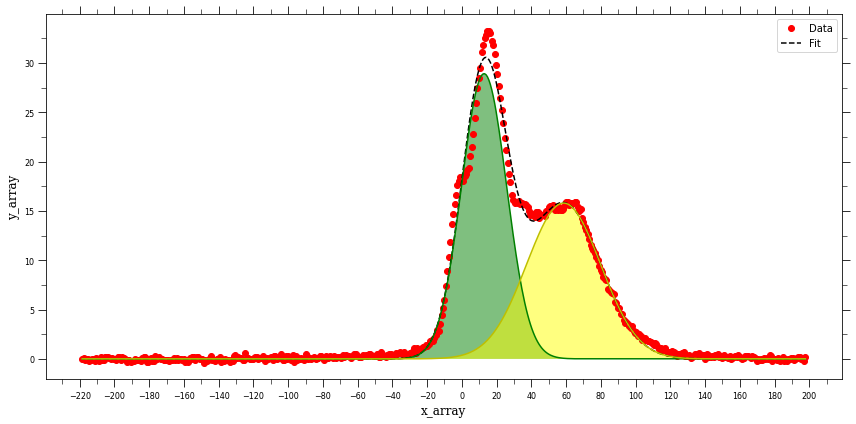

In [65]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.plot(x_array, y_array, "ro", label="Data")
ax1.plot(x_array, _2gaussian(x_array, *popt_2gauss), 'k--', label="Fit")#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

# peak 1
ax1.plot(x_array, gauss_peak_1, "g")
ax1.fill_between(x_array, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)
  
# peak 2
ax1.plot(x_array, gauss_peak_2, "y")
ax1.fill_between(x_array, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5)  

ax1.set_xlabel("x_array",family="serif",  fontsize=12)
ax1.set_ylabel("y_array",family="serif",  fontsize=12)

ax1.legend(loc="best")

ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(50))

ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1.tick_params(axis='both',which='major', direction="out", top="on", right="on", bottom="on", length=8, labelsize=8)
ax1.tick_params(axis='both',which='minor', direction="out", top="on", right="on", bottom="on", length=5, labelsize=8)

fig.tight_layout()
fig.savefig("fit2Gaussian_peaks.png", format="png",dpi=1000)

In [72]:
# now printout the results of the fits. 

In [67]:
# this cell prints the fitting parameters with their errors
peak1 = pars_1[0] / (sigma1*(np.sqrt(2*np.pi)))
peak2 = pars_2[0] / (sigma1*(np.sqrt(2*np.pi)))
perr1 = perr_2gauss[0] / (sigma1*(np.sqrt(2*np.pi)))
perr2 = perr_2gauss[3] / (sigma1*(np.sqrt(2*np.pi)))
peak1 = np.amax(gauss_peak_1)
ipeak1 = np.argmax(gauss_peak_1)
xpeak1 = x_array[ipeak1]
peak2 = np.amax(gauss_peak_2)
ipeak2 = np.argmax(gauss_peak_2)
# if gaussian fit is negative, find minimum
if peak2 < 0.:
    peak2 = np.amin(gauss_peak_2)
    ipeak2 = np.argmin(gauss_peak_2)
xpeak2 = x_array[ipeak2]
print("-------------Peak 1-------------")
print("amplitude = %0.2f (+/-) %0.2f" % (peak1, perr1))
print("center = %0.2f (+/-) %0.2f (%0.2f)" % (pars_1[1], perr_2gauss[1], xpeak1))
print("sigma = %0.2f (+/-) %0.2f" % (pars_1[2], perr_2gauss[2]))
print("area = %0.2f" % np.trapz(gauss_peak_1))
print("--------------------------------")
print("-------------Peak 2-------------")
print("amplitude = %0.2f (+/-) %0.2f" % (peak2, perr2))
print("center = %0.2f (+/-) %0.2f (%0.2f)" % (pars_2[1], perr_2gauss[4], xpeak2))
print("sigma = %0.2f (+/-) %0.2f" % (pars_2[2], perr_2gauss[5]))
print("area = %0.2f" % np.trapz(gauss_peak_2))
print("--------------------------------")

-------------Peak 1-------------
amplitude = 28.91 (+/-) 0.57
center = 12.79 (+/-) 0.16 (13.09)
sigma = 12.98 (+/-) 0.14
area = 1140.78
--------------------------------
-------------Peak 2-------------
amplitude = 15.79 (+/-) 0.62
center = 58.56 (+/-) 0.45 (58.43)
sigma = 21.31 (+/-) 0.43
area = 1023.37
--------------------------------


In [68]:
# Compute difference between the two gaussian model and observations

In [69]:
residual_2gauss = y_array - (_2gaussian(x_array, *popt_2gauss))

In [70]:
# now create a two part plot, with gaussians on top and residuals underneath

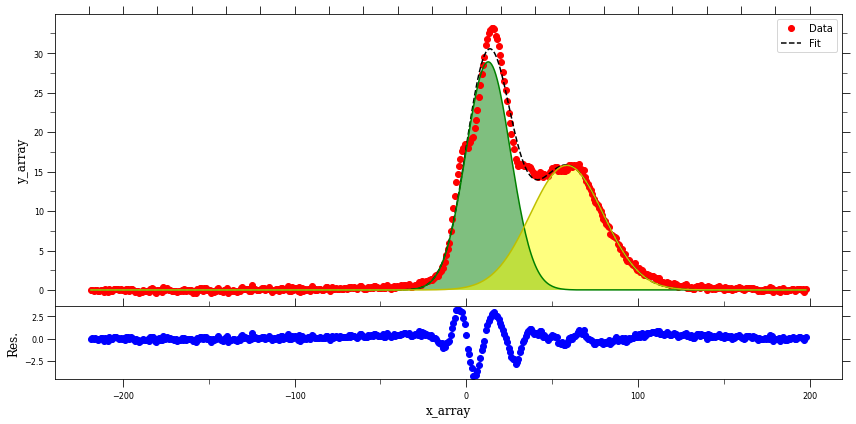

In [71]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2,1, height_ratios=[1,0.25])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
gs.update(hspace=0) 

ax1.plot(x_array, y_array, "ro", label="Data")
ax1.plot(x_array, _2gaussian(x_array, *popt_2gauss), 'k--', label="Fit")#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

# peak 1
ax1.plot(x_array, gauss_peak_1, "g")
ax1.fill_between(x_array, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)
  
# peak 2
ax1.plot(x_array, gauss_peak_2, "y")
ax1.fill_between(x_array, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5)  

# residual
ax2.plot(x_array, residual_2gauss, "bo")

ax2.set_xlabel("x_array",family="serif",  fontsize=12)
ax1.set_ylabel("y_array",family="serif",  fontsize=12)
ax2.set_ylabel("Res.",family="serif",  fontsize=12)

ax1.legend(loc="best")

ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(50))

ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax1.tick_params(axis='x',which='major', direction="out", top="on", right="on", bottom="off", length=8, labelsize=8)
ax1.tick_params(axis='x',which='minor', direction="out", top="on", right="on", bottom="off", length=5, labelsize=8)
ax1.tick_params(axis='y',which='major', direction="out", top="on", right="on", bottom="off", length=8, labelsize=8)
ax1.tick_params(axis='y',which='minor', direction="out", top="on", right="on", bottom="on", length=5, labelsize=8)

ax2.tick_params(axis='x',which='major', direction="out", top="off", right="on", bottom="on", length=8, labelsize=8)
ax2.tick_params(axis='x',which='minor', direction="out", top="off", right="on", bottom="on", length=5, labelsize=8)
ax2.tick_params(axis='y',which='major', direction="out", top="off", right="on", bottom="on", length=8, labelsize=8)
ax2.tick_params(axis='y',which='minor', direction="out", top="off", right="on", bottom="on", length=5, labelsize=8)

fig.tight_layout()
fig.savefig("fit2Gaussian_peaks_resid.png", format="png",dpi=1000)

# Congratulations
### You've examined the emission from the Galactic Plane and found the Velocity of the Arms of the Milky Way